<a href="https://colab.research.google.com/github/Zanakkk/booksapi/blob/main/DENTINATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import json
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam


AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

In [6]:
pip install --upgrade jax jaxlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26


In [60]:
class_mapping = {
    "impaksi": 0,
    "tambalan": 1,
    "karies": 2,
    "prosto": 3,
    "rct": 4,
    "abses": 5,
    "kista": 6,
    "granuloma": 7,
    "implan": 8
}


In [1]:
import json
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

# Fungsi untuk memuat gambar dan resize ke ukuran yang seragam
def load_image(image_path, target_size=(224, 132)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  # Resize gambar ke ukuran yang seragam
        image = image.convert('RGB')  # Pastikan gambar dalam format RGB
        return img_to_array(image)  # Konversi gambar ke array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Fungsi untuk memuat anotasi
def load_annotations(annotation_file):
    try:
        with open(annotation_file, 'r') as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error reading JSON file: {e}")
        return []
    except FileNotFoundError as e:
        print(f"Annotation file not found: {e}")
        return []

# Fungsi untuk mempersiapkan data
def prepare_data(annotation_file, image_folder):
    annotations = load_annotations(annotation_file)
    images = []
    labels = []
    polygons = []  # To store polygons in original size

    # Mapping class labels to indices
    class_mapping = {
        "impaksi": 0,
        "tambalan": 1,
        "karies": 2,
        "prosto": 3,
        "rct": 4,
        "abses": 5,
        "kista": 6,
        "granuloma": 7,
        "implan": 8
    }

    # Loop through each item in the list of annotations
    for annotation in annotations:
        # annotation is a dictionary with a single key (e.g., '2024-76.jpg265191')
        for key, annotation_data in annotation.items():
            filename = annotation_data.get('filename')
            if filename:
                image_path = os.path.join(image_folder, filename)
                image = load_image(image_path)
                if image is not None:
                    images.append(image)

                    label = np.zeros(len(class_mapping))
                    image_polygons = []  # Store polygons in original size for each image

                    regions = annotation_data.get('regions', [])
                    for region in regions:
                        class_name = region['region_attributes'].get('gigi')
                        if class_name in class_mapping:
                            class_index = class_mapping[class_name]
                            label[class_index] = 1  # Multi-label classification

                        shape_attributes = region.get('shape_attributes', {})
                        all_points_x = shape_attributes.get('all_points_x')
                        all_points_y = shape_attributes.get('all_points_y')

                        if all_points_x and all_points_y:
                            image_polygons.append({
                                'all_points_x': all_points_x,
                                'all_points_y': all_points_y
                            })

                    polygons.append(image_polygons)
                    labels.append(label)
            else:
                print(f"Key 'filename' not found in annotation: {annotation_data}")

    return np.array(images), np.array(labels), polygons

# Example usage
annotation_file = 'anotate/testing.json'  # Path to the JSON annotation file
image_folder = 'dataset/testing'  # Path to the image folder

# Call the prepare_data function to process images and annotations
X_test, y_test, original_polygons = prepare_data(annotation_file, image_folder)

print("Number of images loaded:", len(X_test))
print("Number of labels loaded:", len(y_test))
print("Number of polygon sets loaded:", len(original_polygons))


Number of images loaded: 37
Number of labels loaded: 37
Number of polygon sets loaded: 37


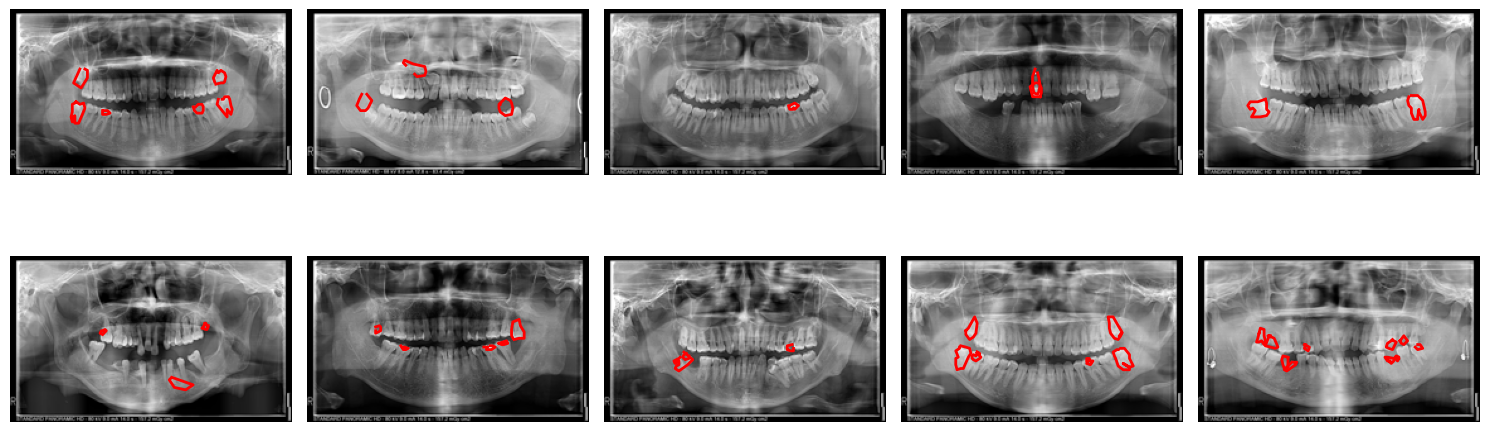

In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

# Fungsi untuk memuat gambar dan resize ke ukuran yang seragam
def load_image(image_path, target_size=(224, 132)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  # Resize gambar ke ukuran yang seragam
        image = image.convert('RGB')  # Pastikan gambar dalam format RGB
        return img_to_array(image)  # Konversi gambar ke array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Fungsi untuk memuat anotasi
def load_annotations(annotation_file):
    try:
        with open(annotation_file, 'r') as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error reading JSON file: {e}")
        return []
    except FileNotFoundError as e:
        print(f"Annotation file not found: {e}")
        return []

# Fungsi untuk me-resize anotasi polygon berdasarkan ukuran gambar baru
def resize_polygons(original_polygons, original_size, target_size):
    resized_polygons = []
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    for polygons in original_polygons:
        resized_image_polygons = []
        for polygon in polygons:
            resized_points_x = [int(x * scale_x) for x in polygon['all_points_x']]
            resized_points_y = [int(y * scale_y) for y in polygon['all_points_y']]
            resized_image_polygons.append({
                'all_points_x': resized_points_x,
                'all_points_y': resized_points_y
            })
        resized_polygons.append(resized_image_polygons)

    return resized_polygons

# Fungsi untuk mempersiapkan data (gambar dan anotasi)
def prepare_data(annotation_file, image_folder, target_size=(224, 132), original_size=(1920, 1080)):
    annotations = load_annotations(annotation_file)
    images = []
    labels = []
    polygons = []  # To store polygons in original size

    # Mapping class labels to indices
    class_mapping = {
        "impaksi": 0,
        "tambalan": 1,
        "karies": 2,
        "prosto": 3,
        "rct": 4,
        "abses": 5,
        "kista": 6,
        "granuloma": 7,
        "implan": 8
    }

    for annotation in annotations:
        for key, annotation_data in annotation.items():
            filename = annotation_data.get('filename')
            if filename:
                image_path = os.path.join(image_folder, filename)
                image = load_image(image_path, target_size)
                if image is not None:
                    images.append(image)

                    label = np.zeros(len(class_mapping))
                    image_polygons = []  # Store polygons in original size for each image

                    regions = annotation_data.get('regions', [])
                    for region in regions:
                        class_name = region['region_attributes'].get('gigi')
                        if class_name in class_mapping:
                            class_index = class_mapping[class_name]
                            label[class_index] = 1  # Multi-label classification

                        shape_attributes = region.get('shape_attributes', {})
                        all_points_x = shape_attributes.get('all_points_x')
                        all_points_y = shape_attributes.get('all_points_y')

                        if all_points_x and all_points_y:
                            image_polygons.append({
                                'all_points_x': all_points_x,
                                'all_points_y': all_points_y
                            })

                    polygons.append(image_polygons)
                    labels.append(label)

    resized_polygons = resize_polygons(polygons, original_size, target_size)

    return np.array(images), np.array(labels), resized_polygons

# Fungsi untuk menampilkan 10 gambar random beserta anotasi polygon yang sudah diresize
def show_random_images_with_annotations(X_data, y_data, polygons, num_samples=10):
    random_indices = np.random.choice(len(X_data), num_samples, replace=False)

    random_X = X_data[random_indices]
    random_polygons = [polygons[i] for i in random_indices]

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(random_X[i].astype(np.uint8))

        for polygon in random_polygons[i]:
            all_points_x = polygon['all_points_x']
            all_points_y = polygon['all_points_y']
            ax.plot(all_points_x, all_points_y, 'r-', linewidth=2)

        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Contoh penggunaan
annotation_file = 'anotate/testing.json'
image_folder = 'dataset/testing'

# Misalkan ukuran asli gambar adalah 1920x1080
original_size = (2200, 1288)
# Target ukuran gambar setelah resize adalah 224x132
target_size = (224, 132)

# Memproses gambar dan anotasi
X_test, y_test, resized_polygons = prepare_data(annotation_file, image_folder, target_size, original_size)

# Menampilkan 10 gambar random beserta anotasinya yang sudah diresize
show_random_images_with_annotations(X_test, y_test, resized_polygons, num_samples=10)


In [3]:
import json
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

# Fungsi untuk memuat gambar dan resize ke ukuran yang seragam
def load_image(image_path, target_size=(224, 132)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  # Pastikan ukuran gambar adalah (224, 132)
        image = image.convert('RGB')  # Konversi ke format RGB
        image_array = img_to_array(image)

        # Periksa apakah urutan dimensi sudah benar
        if image_array.shape != (224, 132, 3):
            # Jika bentuknya salah, tukar dimensi secara eksplisit
            image_array = np.transpose(image_array, (1, 0, 2))  # Tukar urutan tinggi dan lebar

        return image_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None



# Fungsi untuk memuat anotasi
def load_annotations(annotation_file):
    try:
        with open(annotation_file, 'r') as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error reading JSON file: {e}")
        return []
    except FileNotFoundError as e:
        print(f"Annotation file not found: {e}")
        return []

# Fungsi untuk me-resize anotasi polygon berdasarkan ukuran gambar baru
def resize_polygons(original_polygons, original_size, target_size):
    resized_polygons = []
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    for polygons in original_polygons:
        resized_image_polygons = []
        for polygon in polygons:
            resized_points_x = [int(x * scale_x) for x in polygon['all_points_x']]
            resized_points_y = [int(y * scale_y) for y in polygon['all_points_y']]
            resized_image_polygons.append({
                'all_points_x': resized_points_x,
                'all_points_y': resized_points_y
            })
        resized_polygons.append(resized_image_polygons)

    return resized_polygons

# Fungsi untuk mempersiapkan data (gambar dan anotasi)
def prepare_data(annotation_file, image_folder, target_size=(224, 132), original_size=(1920, 1080)):
    annotations = load_annotations(annotation_file)
    images = []
    labels = []
    polygons = []  # To store polygons in original size

    # Mapping class labels to indices
    class_mapping = {
        "impaksi": 0,
        "tambalan": 1,
        "karies": 2,
        "prosto": 3,
        "rct": 4,
        "abses": 5,
        "kista": 6,
        "granuloma": 7,
        "implan": 8
    }

    for annotation in annotations:
        for key, annotation_data in annotation.items():
            filename = annotation_data.get('filename')
            if filename:
                image_path = os.path.join(image_folder, filename)
                image = load_image(image_path, target_size)
                if image is not None:
                    images.append(image)

                    label = np.zeros(len(class_mapping))
                    image_polygons = []  # Store polygons in original size for each image

                    regions = annotation_data.get('regions', [])
                    for region in regions:
                        class_name = region['region_attributes'].get('gigi')
                        if class_name in class_mapping:
                            class_index = class_mapping[class_name]
                            label[class_index] = 1  # Multi-label classification

                        shape_attributes = region.get('shape_attributes', {})
                        all_points_x = shape_attributes.get('all_points_x')
                        all_points_y = shape_attributes.get('all_points_y')

                        if all_points_x and all_points_y:
                            image_polygons.append({
                                'all_points_x': all_points_x,
                                'all_points_y': all_points_y
                            })

                    polygons.append(image_polygons)
                    labels.append(label)

    resized_polygons = resize_polygons(polygons, original_size, target_size)

    return np.array(images), np.array(labels), resized_polygons

# Fungsi untuk mempersiapkan data dari file JSON anotasi dan folder gambar terkait
def prepare_data_for_all_splits():
    # Path untuk data training, validation, dan testing
    annotation_train_file = 'anotate/training.json'
    image_train_folder = 'dataset/training'

    annotation_val_file = 'anotate/validating.json'
    image_val_folder = 'dataset/validating'

    annotation_test_file = 'anotate/testing.json'
    image_test_folder = 'dataset/testing'

    # Ukuran asli dan ukuran target untuk gambar
    original_size = (2200, 1288)
    target_size = (224, 132)

    # Memproses data training
    X_train, y_train, _ = prepare_data(annotation_train_file, image_train_folder, target_size, original_size)

    # Memproses data validation
    X_val, y_val, _ = prepare_data(annotation_val_file, image_val_folder, target_size, original_size)

    # Memproses data testing
    X_test, y_test, _ = prepare_data(annotation_test_file, image_test_folder, target_size, original_size)

    return X_train, y_train, X_val, y_val, X_test, y_test

# Memanggil fungsi untuk mempersiapkan data
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data_for_all_splits()

# Verifikasi hasil data yang disiapkan
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)


(549, 549, 72, 72, 37, 37)

In [26]:
# Fungsi untuk memuat gambar dan resize ke ukuran yang seragam
def load_image(image_path, target_size=(224, 224)):  # Ubah target_size menjadi (224, 224)
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  # Resize ke (224, 224)
        image = image.convert('RGB')  # Konversi ke format RGB
        image_array = img_to_array(image)
        return image_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Fungsi untuk me-resize anotasi polygon berdasarkan ukuran gambar baru
def resize_polygons(original_polygons, original_size, target_size=(224, 224)):  # Target size menjadi (224, 224)
    resized_polygons = []
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    for polygons in original_polygons:
        resized_image_polygons = []
        for polygon in polygons:
            resized_points_x = [int(x * scale_x) for x in polygon['all_points_x']]
            resized_points_y = [int(y * scale_y) for y in polygon['all_points_y']]
            resized_image_polygons.append({
                'all_points_x': resized_points_x,
                'all_points_y': resized_points_y
            })
        resized_polygons.append(resized_image_polygons)

    return resized_polygons

# Memanggil fungsi untuk mempersiapkan data dengan ukuran target (224, 224)
def prepare_data_for_all_splits():
    # Ukuran asli dan ukuran target untuk gambar
    original_size = (2200, 1288)  # Ukuran asli dari dataset
    target_size = (224, 224)  # Ubah target size menjadi (224, 224)

    # Proses data training
    X_train, y_train, _ = prepare_data(annotation_train_file, image_train_folder, target_size, original_size)

    # Proses data validation
    X_val, y_val, _ = prepare_data(annotation_val_file, image_val_folder, target_size, original_size)

    # Proses data testing
    X_test, y_test, _ = prepare_data(annotation_test_file, image_test_folder, target_size, original_size)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [27]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menggunakan ResNet101 dengan input shape yang disesuaikan menjadi 224x132
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 132, 3))

# Membuka lebih banyak layer terakhir untuk fine-tuning
for layer in base_model.layers[-40:]:  # Buka lebih banyak layer untuk fine-tuning
    layer.trainable = True

# Menambahkan lapisan custom di atas model
x = Flatten()(base_model.output)  # Ganti GlobalAveragePooling dengan Flatten
x = Dense(1024, activation='relu')(x)  # Tambah ukuran fully connected layer
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Tambahkan dropout untuk regularisasi
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(9, activation='sigmoid')(x)  # Multi-label classification

# Membuat model akhir dengan input yang sesuai
model = Model(inputs=base_model.input, outputs=output)

# Optimizer
optimizer = Adam(learning_rate=0.00005)  # Mengurangi learning rate untuk pembelajaran yang lebih stabil

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Data Augmentation untuk memperkaya data pelatihan
datagen = ImageDataGenerator(
    rotation_range=40,  # Tingkatkan rotasi untuk augmentasi yang lebih kuat
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,  # Zoom yang lebih agresif
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Normalisasi
)

# Callbacks untuk early stopping, model checkpoint, dan learning rate scheduler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),  # Beri lebih banyak patience
    ModelCheckpoint('best_resnet101_optimized_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)  # Ubah pengaturan learning rate scheduler
]

# Latih model dengan data augmentation dan callback
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),  # Coba batch size lebih besar
                    validation_data=(X_val, y_val),
                    epochs=20,  # Tambah jumlah epochs untuk pembelajaran yang lebih dalam
                    callbacks=callbacks)

# Simpan model terbaik ke file
model.save('model/resnet101_optimized_rontgen.h5')


Epoch 1/20


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Menggunakan VGG16 dengan bobot pretrained dari ImageNet, dan menghapus top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 132, 3))

# Membuka beberapa layer terakhir dari VGG16 untuk fine-tuning
# Membuka lebih banyak layer dari VGG16 (misalnya 12 layer terakhir)
for layer in base_model.layers[-12:]:
    layer.trainable = True


# Menambahkan lapisan custom di atas model VGG16
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Mengurangi ukuran fully connected layer
x = BatchNormalization()(x)
x = Dropout(0.1)(x)  # Menurunkan dropout rate agar model dapat belajar lebih baik
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)  # Regularisasi tambahan tetapi tidak terlalu agresif
output = Dense(9, activation='sigmoid')(x)  # Sigmoid untuk multi-label classification

# Membuat model final
model = Model(inputs=base_model.input, outputs=output)

# Menggunakan Adam optimizer dengan learning rate lebih tinggi
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5)

# Compile model dengan optimizer yang sesuai dan binary_crossentropy untuk multi-label classification
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Membuat ImageDataGenerator untuk augmentasi data
datagen = ImageDataGenerator(
    rotation_range=10,  # Kurangi rotasi
    width_shift_range=0.1,  # Kurangi pergeseran horizontal
    height_shift_range=0.1,  # Kurangi pergeseran vertikal
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.95, 1.05],  # Lebih sedikit variasi brightness
    horizontal_flip=True,
    fill_mode='nearest'
)


# Callbacks untuk early stopping, model checkpoint, dan learning rate scheduler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-7)  # Gunakan faktor penurunan yang lebih kecil
]



# Latih model dengan data augmentation dan callback
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),  # Mencoba batch size yang lebih besar
                    validation_data=(X_val, y_val),
                    epochs=10,
                    callbacks=callbacks)



Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1443 - loss: 0.8503   
Epoch 1: val_loss improved from inf to 130.56003, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 113s 8s/step - accuracy: 0.1453 - loss: 0.8478 - val_accuracy: 0.7639 - val_loss: 130.5600 - learning_rate: 0.0010
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.2061 - loss: 0.7282
Epoch 2: val_loss improved from 130.56003 to 20.31123, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.2079 - loss: 0.7273 - val_accuracy: 0.7639 - val_loss: 20.3112 - learning_rate: 0.0010
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.3084 - loss: 0.6689
Epoch 3: val_loss improved from 20.31123 to 7.16404, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.3080 - loss: 0.6690 - val_accuracy: 0.7639 - val_loss: 7.1640 - learning_rate: 0.0010
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.2859 - loss:

In [1]:
# Evaluasi model pada data testing
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


NameError: name 'model' is not defined

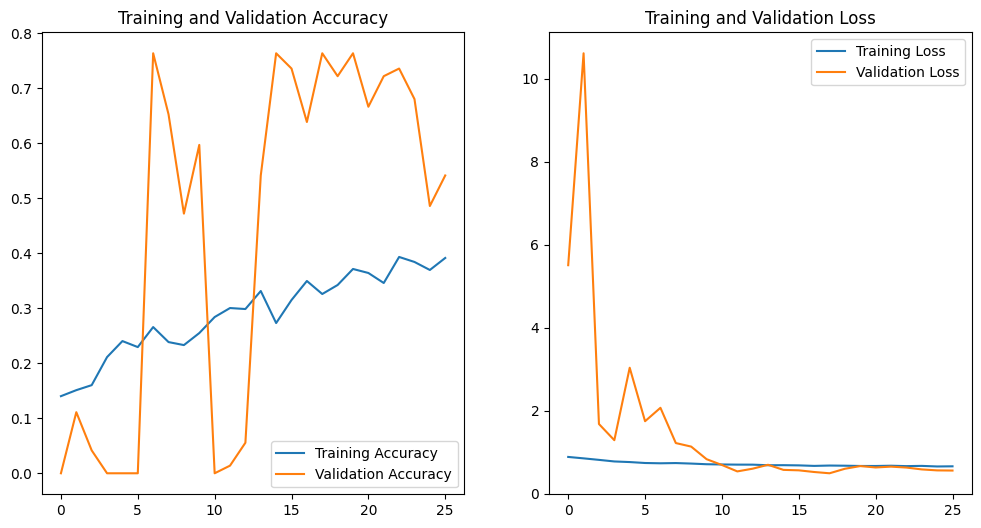

In [30]:
import matplotlib.pyplot as plt

# Memeriksa apakah history sudah tersedia dari pelatihan model
if 'history' in locals() or 'history' in globals():
    # Mengambil data akurasi dan loss dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Membuat array untuk epochs
    epochs_range = range(len(acc))

    # Membuat grafik akurasi
    plt.figure(figsize=(12, 6))

    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Tampilkan grafik
    plt.show()
else:
    print("History object not found. Please make sure the model has been trained and history is available.")


In [14]:
# Simpan model ke file
model.save('model/model_rontgen.h5')


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step


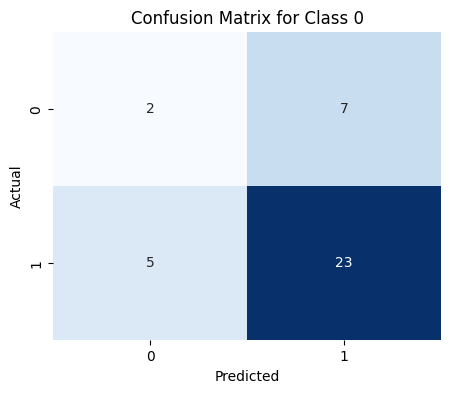

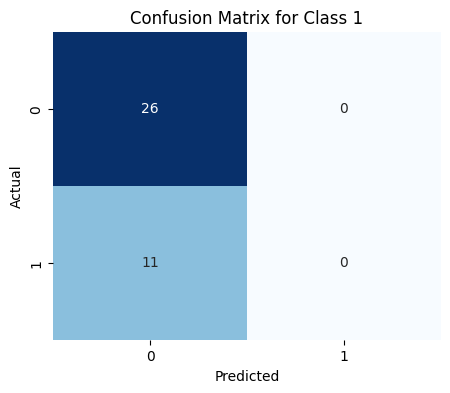

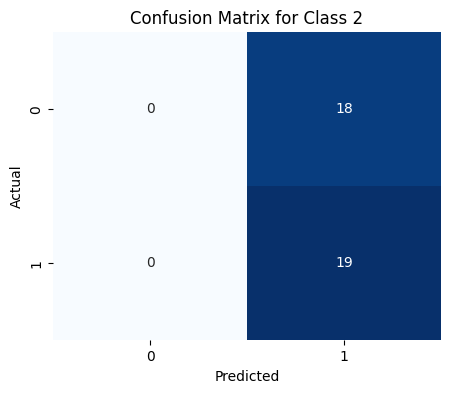

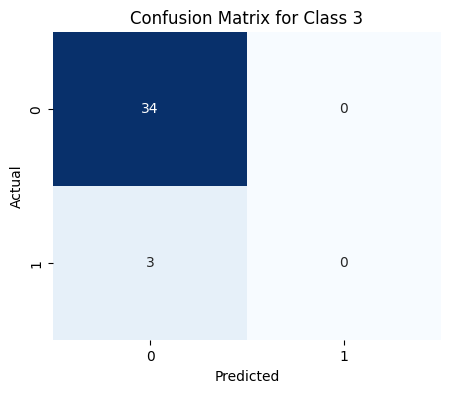

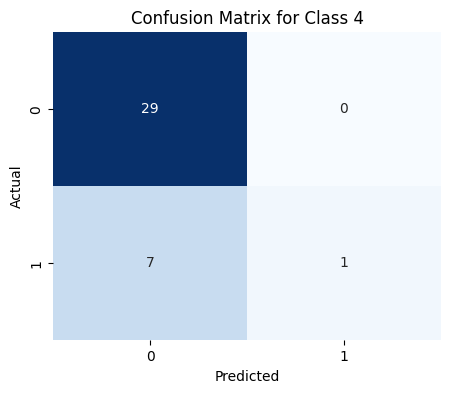

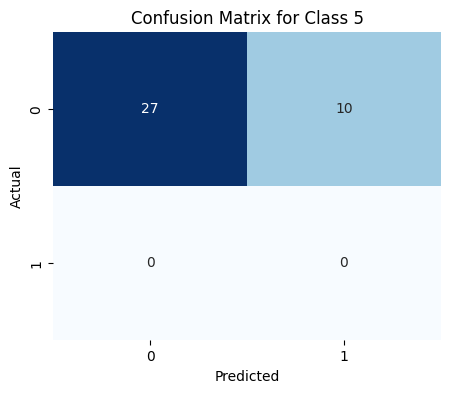

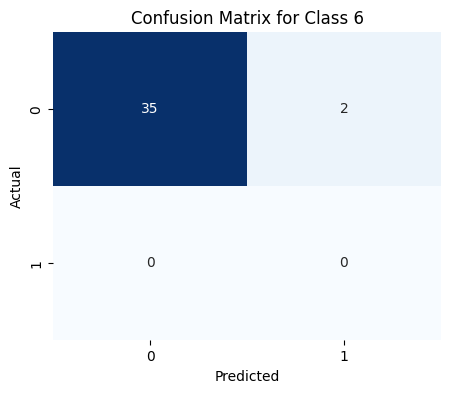

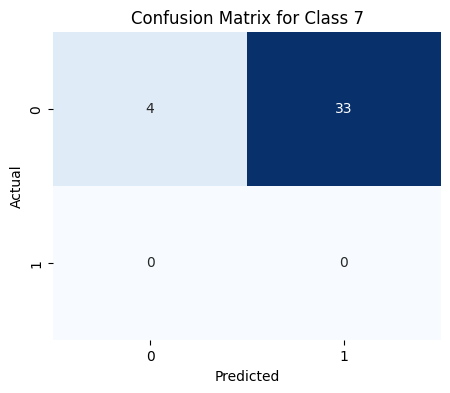

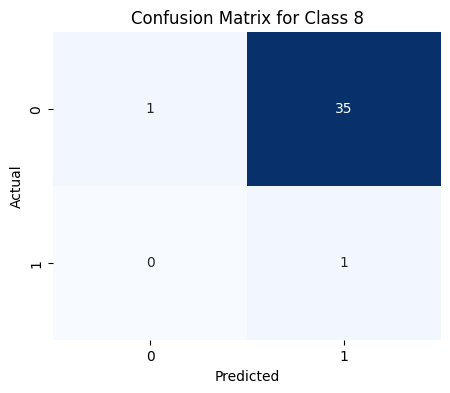

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Lakukan prediksi pada data testing
y_pred = model.predict(X_test)

# Konversi hasil prediksi ke bentuk binary (0 atau 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Menghitung confusion matrix untuk setiap kelas
for i in range(y_test.shape[1]):
    cm = confusion_matrix(y_test[:, i], y_pred_binary[:, i])

    # Visualisasi confusion matrix menggunakan heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


    class_mapping = {
    "impaksi": 0,
    "tambalan": 1,
    "karies": 2,
    "prosto": 3,
    "rct": 4,
    "abses": 5,
    "kista": 6,
    "granuloma": 7,
    "implan": 8
}


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Akurasi: 0.00
Precision: 0.48
Recall: 0.66
F1-Score: 0.19

Classification Report:
              precision    recall  f1-score   support

     impaksi       0.77      0.82      0.79        28
    tambalan       1.00      0.00      0.00        11
      karies       0.51      1.00      0.68        19
      prosto       1.00      0.00      0.00         3
         rct       1.00      0.12      0.22         8
       abses       0.00      1.00      0.00         0
       kista       0.00      1.00      0.00         0
   granuloma       0.00      1.00      0.00         0
      implan       0.03      1.00      0.05         1

   micro avg       0.30      0.63      0.40        70
   macro avg       0.48      0.66      0.19        70
weighted avg       0.76      0.63      0.53        70
 samples avg       0.29      0.66      0.52        70



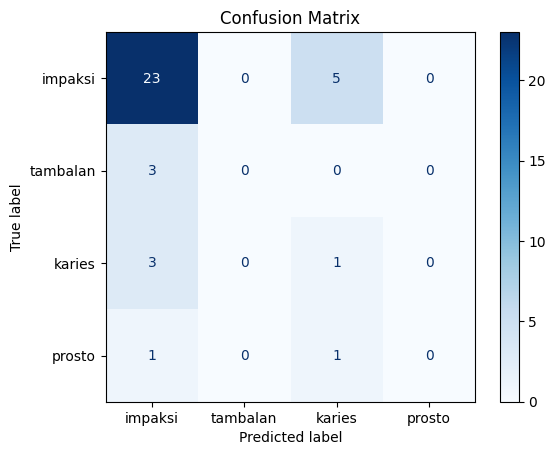

Kelas 4 dilewati karena tidak ada sampel positif.
Kelas 5 dilewati karena tidak ada sampel positif.
Kelas 6 dilewati karena tidak ada sampel positif.
Kelas 7 dilewati karena tidak ada sampel positif.
Kelas 8 dilewati karena tidak ada sampel positif.


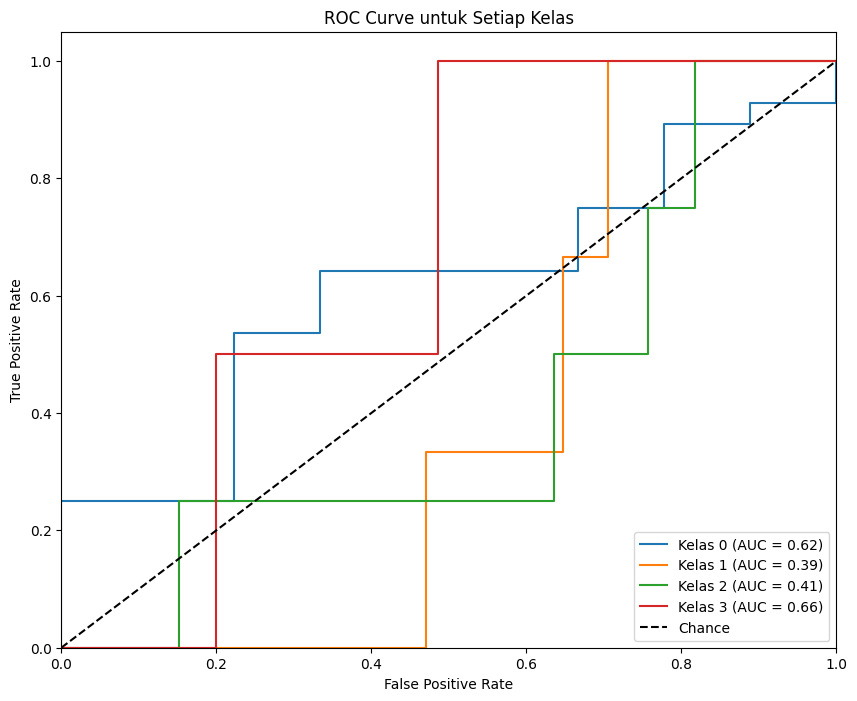

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay

# Mendapatkan prediksi probabilitas dan label prediksi dari model
y_pred_prob = model.predict(X_test)
y_pred_labels = (y_pred_prob > 0.5).astype(int)  # Ubah prediksi probabilitas menjadi label biner (0/1)

# 1. Menghitung Akurasi
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Akurasi: {accuracy:.2f}")

# 2. Precision, Recall, F1-Score untuk setiap kelas
precision = precision_score(y_test, y_pred_labels, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred_labels, average='macro', zero_division=1)
f1 = f1_score(y_test, y_pred_labels, average='macro', zero_division=1)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# 3. Classification Report (Precision, Recall, F1-Score per kelas)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=['impaksi', 'tambalan', 'karies', 'prosto', 'rct', 'abses', 'kista', 'granuloma', 'implan'], zero_division=1))

# 4. Confusion Matrix
# Temukan jumlah kelas yang terdeteksi dalam y_test
unique_labels = np.unique(y_test.argmax(axis=1))

# Buat confusion matrix hanya untuk kelas yang ada dalam y_test
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_labels.argmax(axis=1), labels=unique_labels)

# Tampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[['impaksi', 'tambalan', 'karies', 'prosto', 'rct', 'abses', 'kista', 'granuloma', 'implan'][i] for i in unique_labels])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 5. Plot ROC Curve dan Hitung AUC untuk Setiap Kelas
def plot_roc_curve(y_test, y_pred_prob, num_classes):
    # Binarize y_test jika belum
    y_test_bin = label_binarize(y_test.argmax(axis=1), classes=np.arange(num_classes))

    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        if np.sum(y_test_bin[:, i]) == 0:
            print(f"Kelas {i} dilewati karena tidak ada sampel positif.")
            continue

        # Menghitung ROC Curve dan AUC untuk setiap kelas
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Kelas {i} (AUC = {auc:.2f})')

    # Menambahkan garis diagonal sebagai baseline
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve untuk Setiap Kelas')
    plt.legend(loc="lower right")
    plt.show()

# Menampilkan ROC Curve
num_classes = 9  # Jumlah kelas
plot_roc_curve(y_test, y_pred_prob, num_classes)
